In [ ]:
!pip install tiktoken

In [ ]:
import torch
import torch.nn as nn
import tiktoken

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
gpt_124M = {
    "vocab_size": 50257,
    "con_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "bais": False
}

In [ ]:
class dummyGPT2(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb=nn.Embedding(cfg["con_len"],cfg["emb_dim"])
    self.drop=nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[dummytrfblock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = dummylayernorm(cfg)
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_emb = self.tok_emb(in_idx)
    pos_emb = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
    x = tok_emb + pos_emb
    x = self.drop(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class dummytrfblock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

class dummylayernorm(nn.Module):
  def __init__(self,normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self,x):
    return x

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = dummyGPT2(gpt_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer Normalization

In [ ]:

torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [ ]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
mean,var

(tensor([[0.1324],
         [0.2170]], grad_fn=<MeanBackward1>),
 tensor([[0.0231],
         [0.0398]], grad_fn=<VarBackward0>))

In [ ]:
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
mean,var

(tensor([[9.9341e-09],
         [1.9868e-08]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))

In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Feed forward Network

In [ ]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))

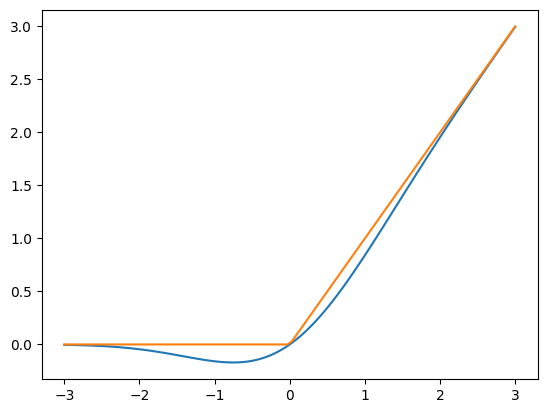

In [ ]:
import matplotlib.pyplot as plt
gelu,relu = GeLU(),nn.ReLU()

x= torch.linspace(-3,3,100)
y_gelu = gelu(x)
y_relu = relu(x)

plt.plot(x.detach(),y_gelu.detach(),label="GeLU")
plt.plot(x.detach(),y_relu.detach(),label="ReLU")

In [ ]:
class feedforward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GeLU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layer(x)

In [ ]:
ffn = feedforward(gpt_124M)
batch_example = torch.rand(2,3,768)
ffn(batch_example)

tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)

# Skip layer

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GeLU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GeLU())
        ])

    def forward(self,x):
      for layer in self.layers:
        layer_output = layer(x)
        if self.use_shortcut and x.shape == layer_output.shape:
          x=x+layer_output
        else:
          x=layer_output
      return x

In [ ]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print("Model without shortcut:")
print(model_without_shortcut(sample_input))

Model without shortcut:
tensor([[0.0610]], grad_fn=<MulBackward0>)


In [ ]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846952389925718
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976


# LLM Transfer Block

In [ ]:
gpt_124M = {
    "vocab_size": 50257,
    "con_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "bias": False
}

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))


In [ ]:
class feedforward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GeLU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layer(x)

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(cfg["emb_dim"],cfg["emb_dim"],cfg["con_len"],cfg["drop_rate"],cfg["n_heads"],cfg["bias"])
    self.ffn = feedforward(cfg)
    self.ln1 = LayerNorm(cfg["emb_dim"])
    self.ln2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x=self.ln1(x)
    x=self.att(x)
    x=self.drop_shortcut(x)
    x=x+shortcut
    shortcut=x
    x=self.ln2(x)
    x=self.ffn(x)
    x=self.drop_shortcut(x)
    x=x+shortcut

    return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(gpt_124M)
output = block(x)
print(x,output)
x.shape,output.shape

tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]]) tensor([[[ 0.1648,  0.4002, -0.0749,  ...,  1.2646,  0.3324,  0.7243],
         [ 0.0293,  0.0498,  0.2529,  ...,  0.4698,  0.1281,  0.9749],
         [ 0.5532,  0.5788, -0.0310,  ...,  1.1544,  0.3947,  0.7600],
         [ 0.1631,  0.7128,  0.7271,  ...,  0.3312,  0.5730,  0.9258]],

        [[ 0.1787,  1.1682,  0.5810,  ...,  0.1828,  0.0073, -0.5603],
         [-0.2920,  0.6318,  0.2002,  ...,  0.3218,  0.4670, -0.0383],
         [ 0.9275,  0.4203,  0.3183,  ...,  0.37

(torch.Size([2, 4, 768]), torch.Size([2, 4, 768]))

In [ ]:
class GPT_2(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["con_len"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias = False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [ ]:
torch.manual_seed(123)
batch = torch.randint(0, gpt_124M["vocab_size"], (2, 4), dtype=torch.long)
model = GPT_2(gpt_124M)
out=model(batch)

In [ ]:
t_params = sum(p.numel() for p in model.parameters()) # total params
t_params

163009536

In [ ]:
#total memory in MB
t_size = t_params * 4
t_size = t_size/(1024*1024)
t_size

621.83203125

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  # Move idx to the same device as the model
  idx = idx.to(next(model.parameters()).device)  # Move idx to the model's device

  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

In [ ]:
 tx ="hello, I am"
 encoded = tokenizer.encode(tx)
 print(encoded)
 encoded_tensor = torch.tensor(encoded).unsqueeze(0)
 print(encoded_tensor.shape)

[31373, 11, 314, 716]
torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(model=model,idx=encoded_tensor,max_new_tokens=6,context_size=gpt_124M["con_len"])
out,out.shape

(tensor([[31373,    11,   314,   716, 49562,  7495, 34029, 26762, 30205, 40485]]),
 torch.Size([1, 10]))

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'hello, I amFraaos bumpsibogeantmicrosoft'

In [ ]:
def text_to_token(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_cotext = "every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token(start_cotext,tokenizer),
    max_new_tokens=10,
    context_size=gpt_124M["con_len"]
)
token_to_text(token_ids,tokenizer)

'every effort moves youofiRECTchildren dilefit Chase SymptomsUntildamageKick'

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[47356],
         [ 5432],
         [14808]],

        [[19415],
         [18190],
         [20376]]])


In [ ]:
print(f"Targets batch 1: {token_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: diagnSS ((


cross-entropy loss

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-11.5150, -10.6437, -10.9999, -11.2291, -10.6628, -10.6709])


In [ ]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.9536)


In [ ]:
neg_avg_log_probas = avg_log_probas*-1
neg_avg_log_probas

tensor(10.9536)

In [ ]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9536)


perplexity loss

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(57157.2109)


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  val_loss = calc_loss_loader(val_loader,model,device)

  print(f"Train loss: {train_loss:.4f}")
  print(f"Val loss: {val_loss:.4f}")

# Temprature

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

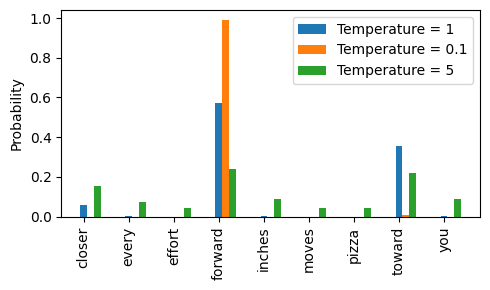

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

# Top-K-sampling